
Problem 1: Linear BVP - Results
Equation: -u'' = e^{sin(x)}, u(0)=0, u(1)=0
N=    32, h=3.125e-02, max_err_vs_ref=4.308e-06, residual=3.297e+00
N=    64, h=1.562e-02, max_err_vs_ref=1.077e-06, residual=3.327e+00
N=   128, h=7.812e-03, max_err_vs_ref=2.691e-07, residual=3.342e+00
N=   256, h=3.906e-03, max_err_vs_ref=6.727e-08, residual=3.349e+00
N=   512, h=1.953e-03, max_err_vs_ref=1.682e-08, residual=3.353e+00
N=  1024, h=9.766e-04, max_err_vs_ref=4.204e-09, residual=3.355e+00

Richardson estimates (max norm on coarse grid):
32->64, max Richardson estimate = 1.077e-06
64->128, max Richardson estimate = 2.691e-07
128->256, max Richardson estimate = 6.728e-08
256->512, max Richardson estimate = 1.682e-08
512->1024, max Richardson estimate = 4.205e-09

fine N=2000, h=5.000e-04, residual=3.356e+00
fine N=4000, h=2.500e-04, residual=3.356e+00
fine N=8000, h=1.250e-04, residual=3.357e+00

Estimated practical minimum residual ~ 3.356e+00


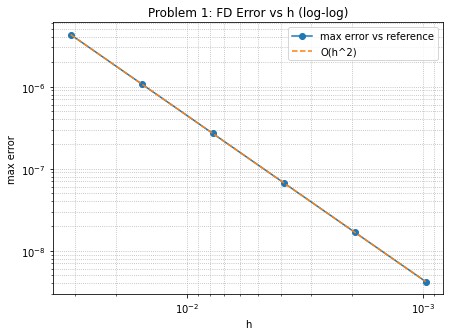

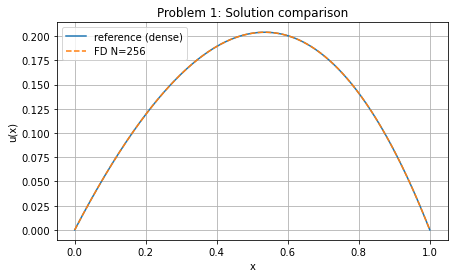


Problem 2: Nonlinear BVP - Results
Equation: -u'' + sin(u) = 0, u(0)=1, u(1)=1
N=    32, h=3.125e-02, Newton iters=3, residual_inf=1.396e-13
N=    64, h=1.562e-02, Newton iters=3, residual_inf=6.067e-13
N=   128, h=7.812e-03, Newton iters=3, residual_inf=3.146e-12
N=   256, h=3.906e-03, Newton iters=3, residual_inf=1.233e-11
N=   512, h=1.953e-03, Newton iters=3, residual_inf=4.895e-11

Nonlinear convergence estimates (max norm error between consecutive grids):
32 -> 64: max difference ≈ 3.310e-06
64 -> 128: max difference ≈ 8.274e-07
128 -> 256: max difference ≈ 2.068e-07
256 -> 512: max difference ≈ 5.171e-08


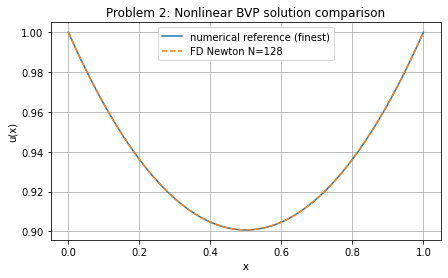

In [1]:
"""
Problem 1: Linear Boundary Value Problem
Equation: -u'' = e^{sin(x)},  u(0)=0, u(1)=0
Solver: Finite difference method with Thomas tridiagonal solver (TDMA)

Problem 2: Nonlinear Boundary Value Problem
Equation: -u'' + sin(u) = 0,  u(0)=1, u(1)=1
Solver: Finite difference method + Newton iteration with TDMA
"""

import numpy as np
import math
import matplotlib.pyplot as plt

# --------------------------
# Thomas algorithm (TDMA)
# --------------------------
def thomas_solve(a, b, c, d):
    n = len(b)
    cp = np.empty(n-1, dtype=float)
    dp = np.empty(n, dtype=float)
    cp[0] = c[0]/b[0]
    dp[0] = d[0]/b[0]
    for i in range(1,n-1):
        denom = b[i]-a[i-1]*cp[i-1]
        cp[i] = c[i]/denom
        dp[i] = (d[i]-a[i-1]*dp[i-1])/denom
    dp[n-1] = (d[n-1]-a[n-2]*dp[n-2])/(b[n-1]-a[n-2]*cp[n-2])
    x = np.empty(n, dtype=float)
    x[-1] = dp[-1]
    for i in range(n-2,-1,-1):
        x[i] = dp[i]-cp[i]*x[i+1]
    return x

# --------------------------
# Problem 1 routines
# --------------------------
def rhs_func(x):
    return np.exp(np.sin(x))

class BVPSolverTDMA:
    def __init__(self, N):
        self.N = N
        self.h = 1.0/N
        self.x = np.linspace(self.h,1.0-self.h,N-1)
    def assemble_and_solve(self):
        m = len(self.x)
        if m==0:
            return np.array([0.0,1.0]), np.array([0.0,0.0])
        a = -1.0*np.ones(m-1)
        b = 2.0*np.ones(m)
        c = -1.0*np.ones(m-1)
        rhs = (self.h**2)*rhs_func(self.x)
        u_interior = thomas_solve(a,b,c,rhs)
        u_full = np.zeros(m+2)
        u_full[1:-1] = u_interior
        x_full = np.linspace(0.0,1.0,m+2)
        return x_full, u_full
    def compute_residual(self, u_full):
        uxx = (u_full[:-2]-2*u_full[1:-1]+u_full[2:])/(self.h**2)
        f_at_nodes = rhs_func(self.x)
        res = np.linalg.norm(uxx-f_at_nodes)*math.sqrt(self.h)
        return res

def build_reference(num_points=200000):
    x_ref = np.linspace(0.0,1.0,num_points+1)
    fx = rhs_func(x_ref)
    alpha = np.trapz((1.0-x_ref)*fx,x_ref)
    dx = 1.0/num_points
    A_cum = np.cumsum(0.5*(fx[:-1]+fx[1:])*dx)
    A_cum = np.concatenate(([0.0],A_cum))
    B_cum = np.cumsum(0.5*(x_ref[:-1]*fx[:-1]+x_ref[1:]*fx[1:])*dx)
    B_cum = np.concatenate(([0.0],B_cum))
    J = x_ref*A_cum-B_cum
    u_ref = alpha*x_ref-J
    return x_ref,u_ref,alpha

def convergence_experiment(mesh_list, ref_points=200000):
    x_ref,u_ref,_ = build_reference(num_points=ref_points)
    results=[]
    print('\n'+'='*60)
    print("Problem 1: Linear BVP - Results")
    print("Equation: -u'' = e^{sin(x)}, u(0)=0, u(1)=0")
    print('='*60)
    for N in mesh_list:
        solver = BVPSolverTDMA(N)
        x_full,u_full = solver.assemble_and_solve()
        u_ref_on_grid = np.interp(x_full,x_ref,u_ref)
        maxerr = np.max(np.abs(u_full-u_ref_on_grid))
        residual = solver.compute_residual(u_full)
        results.append({'N':N,'h':solver.h,'x':x_full,'u':u_full,
                        'residual':residual,'max_error_vs_ref':maxerr})
        print(f"N={N:6d}, h={solver.h:.3e}, max_err_vs_ref={maxerr:.3e}, residual={residual:.3e}")
    return results,x_ref,u_ref

# --------------------------
# Problem 1: Richardson & Fine residual
# --------------------------
def compute_richardson_estimates(results):
    print('\nRichardson estimates (max norm on coarse grid):')
    for i in range(1,len(results)):
        u_coarse = results[i-1]['u']
        u_fine_interp = np.interp(results[i-1]['x'], results[i]['x'], results[i]['u'])
        rich_err = np.max(np.abs(u_fine_interp - u_coarse)/3.0)
        print(f"{results[i-1]['N']}->{results[i]['N']}, max Richardson estimate = {rich_err:.3e}")

def fine_grid_residuals():
    fine_N_list = [2000,4000,8000]
    print()
    min_res = float('inf')
    for N in fine_N_list:
        solver = BVPSolverTDMA(N)
        x_full,u_full = solver.assemble_and_solve()
        residual = solver.compute_residual(u_full)
        print(f"fine N={N}, h={solver.h:.3e}, residual={residual:.3e}")
        if residual < min_res:
            min_res = residual
    print(f"\nEstimated practical minimum residual ~ {min_res:.3e}")

# --------------------------
# Problem 2 routines
# --------------------------
class NonlinearBVPSolverTDMA:
    def __init__(self,N,tol=1e-12,maxiter=50):
        self.N=N
        self.h=1.0/N
        self.x=np.linspace(self.h,1.0-self.h,N-1)
        self.tol=tol
        self.maxiter=maxiter
    def initial_guess(self):
        return np.ones(len(self.x))
    def solve_newton(self,verbose=False):
        m=len(self.x)
        if m==0:
            return np.array([1.0,1.0]),0
        u=self.initial_guess()
        for k in range(self.maxiter):
            u_ext = np.concatenate(([1.0],u,[1.0]))
            r = (-u_ext[:-2]+2*u_ext[1:-1]-u_ext[2:])/(self.h**2)+np.sin(u)
            res_norm = np.linalg.norm(r,ord=np.inf)
            if verbose:
                print(f"Newton iter {k:2d}, ||r||_inf = {res_norm:.3e}")
            if res_norm<self.tol:
                return np.concatenate(([1.0],u,[1.0])),k
            a=(-1.0/self.h**2)*np.ones(m-1)
            b=(2.0/self.h**2)+np.cos(u)
            c=(-1.0/self.h**2)*np.ones(m-1)
            delta = thomas_solve(a,b,c,-r)
            u = u + delta
            if np.linalg.norm(delta,ord=np.inf)<1e-14:
                break
        return np.concatenate(([1.0],u,[1.0])),k
    def compute_residual(self,u_full):
        u_ext = u_full
        r=(-u_ext[:-2]+2*u_ext[1:-1]-u_ext[2:])/(self.h**2)+np.sin(u_ext[1:-1])
        return np.linalg.norm(r,ord=np.inf)

def nonlinear_convergence(mesh_list,tol=1e-12):
    results=[]
    print('\n'+'='*60)
    print("Problem 2: Nonlinear BVP - Results")
    print("Equation: -u'' + sin(u) = 0, u(0)=1, u(1)=1")
    print('='*60)
    for N in mesh_list:
        solver = NonlinearBVPSolverTDMA(N,tol=tol)
        u_full,nit = solver.solve_newton(verbose=False)
        res_inf = solver.compute_residual(u_full)
        results.append({'N':N,'h':solver.h,'u':u_full,'x':np.linspace(0,1,len(u_full)),
                        'res_inf':res_inf,'nit':nit})
        print(f"N={N:6d}, h={solver.h:.3e}, Newton iters={nit}, residual_inf={res_inf:.3e}")
    rates=[]
    for i in range(1,len(results)):
        u_coarse = results[i-1]['u']
        x_coarse = results[i-1]['x']
        u_fine_interp = np.interp(x_coarse,results[i]['x'],results[i]['u'])
        err = np.max(np.abs(u_coarse-u_fine_interp))
        rates.append(err)
    return results,rates

# --------------------------
# Main execution
# --------------------------
if __name__=='__main__':
    # Problem 1
    mesh_list=[32,64,128,256,512,1024]
    results,x_ref,u_ref = convergence_experiment(mesh_list,ref_points=100000)

    # Richardson & Fine residual
    compute_richardson_estimates(results)
    fine_grid_residuals()

    hs = np.array([r['h'] for r in results])
    errs = np.array([r['max_error_vs_ref'] for r in results])
    plt.figure(figsize=(7,5))
    plt.loglog(hs,errs,'o-',label='max error vs reference')
    h_line = np.array([hs[0],hs[-1]])
    plt.loglog(h_line,(h_line**2)*errs[0]/(h_line[0]**2),'--',label='O(h^2)')
    plt.gca().invert_xaxis()
    plt.xlabel('h')
    plt.ylabel('max error')
    plt.title('Problem 1: FD Error vs h (log-log)')
    plt.grid(True,which='both',ls=':')
    plt.legend()
    plt.show()

    mid=len(results)//2
    plt.figure(figsize=(7,4))
    plt.plot(x_ref,u_ref,label='reference (dense)')
    plt.plot(results[mid]['x'],results[mid]['u'],'--',label=f'FD N={results[mid]["N"]}')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Problem 1: Solution comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Problem 2
    mesh_list_nl=[32,64,128,256,512]
    nl_results,nl_rates = nonlinear_convergence(mesh_list_nl,tol=1e-12)
    print('\nNonlinear convergence estimates (max norm error between consecutive grids):')
    for i in range(len(nl_rates)):
        print(f"{mesh_list_nl[i]} -> {mesh_list_nl[i+1]}: max difference ≈ {nl_rates[i]:.3e}")

    plt.figure(figsize=(7,4))
    idx_plot = len(nl_results)//2
    x_ref_nl = nl_results[-1]['x']
    u_ref_nl = nl_results[-1]['u']
    plt.plot(x_ref_nl,u_ref_nl,label='numerical reference (finest)')
    plt.plot(nl_results[idx_plot]['x'],nl_results[idx_plot]['u'],'--',
             label=f'FD Newton N={nl_results[idx_plot]["N"]}')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Problem 2: Nonlinear BVP solution comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
